<h1><center><b>Branching Output Layers with Keras</b></center></h1>

<br><br>
<h2>1. Overview</h2>

<p>Sometimes, when training a convolutional neural network (CNN), our labels might have more than one dimension. In a typical classification problem, our CNN will probably have to predict a label that belongs to a pool of possible labels. For example, let's say we have an image dataset that consists of cats and dogs. When our model is presented with an image, it will have to decide whether the image is either a cat or a dog. However, what happens when we are presented with a dataset with labels that are multi-dimensional?
    
    <br><br>In this notebook, I will show a possible way to setup a keras CNN model that can process an output with 2 dimensions. The dataset used was provided by Kaggle. It consists of 5-character, alphanumerical captcha images. The pool of possible alphanumerical characters only involve lower-cased letters and integers.
    
    <br><br>The goal for this notebook is to provide insight on how to setup a CNN model that can process data with 2 dimensional labels. The idea can also be used for data that may contain more than 2 dimensions.
</p>

In [1]:
import matplotlib.pyplot as plt
import glob, os, gc, string
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from tensorflow import keras
from torchvision import transforms
from PIL import Image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# for markdown styling
from IPython.core.display import HTML
css = open("style/custom.css", "r").read()
HTML(css)

<br><br>
<h2>2. Data Preprocessing</h2>

<h4><b>Load data</b></h4>

In [3]:
X = []

for image in glob.glob('data/*'):
    X.append(np.asarray(Image.open(image).convert('L')))

In [4]:
X = np.array(X)

In [5]:
print(X.shape)

(1070, 50, 200)


<br><br>
<h4><b>Reshape and normalize data</b></h4>

In [6]:
X = X / 255.0
X = X.reshape(-1, 50, 200, 1)

In [7]:
print(X.shape)

(1070, 50, 200, 1)


<br><br>
<h4><b>Get labels</b></h4>

In [8]:
labels = []

for image in glob.glob('data/*'):
    label = os.path.splitext(os.path.basename(image))[0]
    labels.append(label)
    
print(len(labels))

1070


<br><br>
<h4><b>Print samples</b></h4>

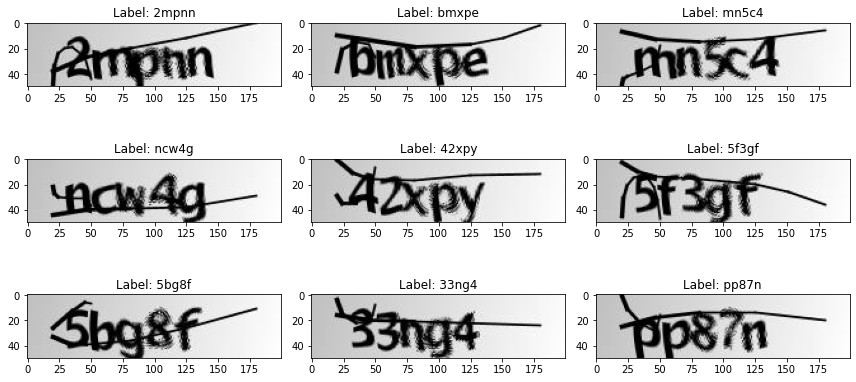

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(12,6))
used_idx = []

for i, ax in enumerate(axes.flatten()):
    idx = np.random.randint(0, len(X), dtype=int)
    
    while idx in used_idx:
        idx = np.random.randint(0, len(X), dtype=int)
    used_idx.append(idx)
    
    ax.imshow(X[idx], cmap='gray')
    
    ax.set_title('Label: ' + str(labels[idx]))
    
fig.tight_layout()

<br><br>
<h4><b>One-hot encode labels</b></h4>

<p>When one-hot encoding our labels, we need to keep in mind that they are 2-dimensional. There will be 5 rows and 36 columns. Each row will represent a character index within each captcha. Remember that every captcha only consists of 5 characters. The columns will represent the pool of possible characters. Since the pool of possible characters only involve lower-cased letters and integers, that leaves us with 36 columns.
</p>

In [10]:
# store alphanumeric characters; lower-case letters and integers
alphanumeric = ''.join(("0123456789",string.ascii_lowercase))
chars = np.asarray([ch for ch in alphanumeric])

In [11]:
print('Num of chars:', chars.size, '\n\n', chars)

Num of chars: 36 

 ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h'
 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [12]:
letters = np.asarray([[i for i in j] for j in labels])
T = np.array([chars == np.asarray([[[i for i in j] for j in k] for k in letters])[:,None]]).astype(int).reshape((1070,5,36))

In [13]:
print('Shape:', T.shape, '\n\nLabel:', labels[0], '\n\nChars:', letters[0], '\n\nEncoded:\n\n', T[0])

Shape: (1070, 5, 36) 

Label: 226md 

Chars: ['2' '2' '6' 'm' 'd'] 

Encoded:

 [[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


<br><br>
<h4><b>Split data into train and test sets</b></h4>

In [14]:
# shuffle indices and partition data into train and test sets
N = X.shape[0]
idxs = np.random.permutation(N)

# split dataset into a 1/5 ratio
split = 0.8
ratio = int(round(N * split))

# assign first ratio to the training sets
Xtrain = X[idxs[0:ratio], :]
Ttrain = T[idxs[0:ratio], :]

# assign remaining values to the test sets
Xtest = X[idxs[ratio:], :]
Ttest = T[idxs[ratio:], :]

In [15]:
# swap first 2 dimensions of the test sets
Ttrain = np.transpose(Ttrain, (1,0,2))
Ttest = np.transpose(Ttest, (1,0,2))

In [16]:
print("Xtrain shape: ", Xtrain.shape)
print("Ttrain shape: ", Ttrain.shape)
print("Xtest shape: ", Xtest.shape)
print("Ttest shape: ", Ttest.shape)

Xtrain shape:  (856, 50, 200, 1)
Ttrain shape:  (5, 856, 36)
Xtest shape:  (214, 50, 200, 1)
Ttest shape:  (5, 214, 36)


<br><br>
<h2>3. Setting up the Model</h2>

<p>Since our labels are 2-dimensional, we need to make it so that the model branches into multiple dense layers.
    
    <br><br>In my previous project with keras (Digit Classification), I utilized <code>Sequential</code> when creating the CNN model.
</p>

<br>

```python
    model = keras.Sequential([keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
                             keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
                             keras.layers.Dropout(0.25),
                             keras.layers.Conv2D(64, (3,3), activation='relu'),
                             keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
                             keras.layers.Dropout(0.25),
                             keras.layers.Flatten(),
                             keras.layers.Dense(120, activation='relu'),
                             keras.layers.Dense(84, activation='relu'),
                             keras.layers.Dense(10, activation='softmax')])
```

<br>

<p>While the architecture for this model will be similar, we'll need to make some modifications for it to process multiple output (branching) layers.
    
    <br><br>We'll start by creating some useful variables and setting up our input and output layers.
</p>

In [17]:
input_shape = Xtrain.shape[1:]
out_dim_1, out_dim_2, out_dim_3 = Ttrain.shape

inputs = keras.layers.Input(shape=input_shape)

outputs = []

```python
    input_shape = Xtrain.shape[1:]
    out_dim_1, out_dim_2, out_dim_3 = Ttrain.shape
```

<br>

<p>The shape of our input layer must be the same as the shape of each individual input. In this case, the shape is <code>(50, 200, 1)</code>.
    
    <br><br>Next, the <code>out_dim_1, out_dim_2, out_dim_3</code> variables are used to hold the dimensions for our branching layers. <code>out_dim_1</code> will determine the number of dense layers (<code>5</code>) while <code>out_dim_3</code> will determine the size of each dense layer (<code>36</code>).
</p>

<br>

```python
    inputs = keras.layers.Input(shape=input_shape)
    outputs = []
```

<br>

<p><code>inputs</code> is the first layer in our model. As the name suggests, it determines the shape of our inputs. The <code>outputs</code> array will hold each branching layer when we create them later on.
    
    <br><br>Now, we can setup some convolution layers.
</p>

In [18]:
# first convolution
conv2d_1 = keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
mp2d_1 = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(conv2d_1)
do_1 = keras.layers.Dropout(0.25)(mp2d_1)

# second convolution
conv2d_2 = keras.layers.Conv2D(64, (3,3), activation='relu')(do_1)
mp2d_2 = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(conv2d_2)
do_2 = keras.layers.Dropout(0.25)(mp2d_2)

# flatten input
flatten_layer = keras.layers.Flatten()(do_2)

```python
    # first convolution
    conv2d_1 = keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
    mp2d_1 = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(conv2d_1)
    do_1 = keras.layers.Dropout(0.25)(mp2d_1)

    # second convolution
    conv2d_2 = keras.layers.Conv2D(64, (3,3), activation='relu')(do_1)
    mp2d_2 = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(conv2d_2)
    do_2 = keras.layers.Dropout(0.25)(mp2d_2)
```

<br>

<p>Similarly to the <code>Sequential</code> model, here I create two convolution layers where each are followed by a max pooling and dropout layer. The only difference is in how the layers are initialized. We can see that the first convolution layer includes an <code>(inputs)</code> argument after it. This syntax is used to the connect the initializing layer to the argument layer. So, <code>inputs</code> connects to <code>conv2d_1</code>, then <code>conv2d_1</code> connects to <code>mp2d_1</code>, and so on.
    
    <br><br>We setup this sequence manually so that it will be easier to initialize our model after we create our output dense layers.
</p>

<br>

```python
    # flatten input
    flatten_layer = keras.layers.Flatten()(do_2)
```

<br>

<p>Not much to say here. This layer simply flattens our data for further abstraction.
    
    <br><br>Next is our dense layers.
</p>

In [19]:
for i in range(out_dim_1):
        dense_1 = keras.layers.Dense(144, activation='relu')(flatten_layer)
        dense_2 = keras.layers.Dense(72, activation='relu')(dense_1)
        softmax_layer = keras.layers.Dense(out_dim_3, activation='softmax')(dense_2)
        outputs.append(softmax_layer)

```python
    for i in range(out_dim_1):
        dense_1 = keras.layers.Dense(144, activation='relu')(flatten_layer)
        dense_2 = keras.layers.Dense(72, activation='relu')(dense_1)
        softmax_layer = keras.layers.Dense(out_dim_3, activation='softmax')(dense_2)
        outputs.append(softmax_layer)
```

<br>

<p>Here, we have a <code>for-loop</code> that is set to the range of <code>out_dim_1</code> (<code>5</code>).
    
    <br><br>For every iteration, it will create 3 dense layers. The last dense layer is named <code>softmax_layer</code> in order to identify that this is the output layer. Notice that it uses the <code>out_dim_3</code> variable, which represents the number of possible classes that each dense layer can predict (<code>36</code> alphanumerical characters). Each output layer is appended to our <code>outputs</code> array that we created earlier.
    
    <br><br>After the loop is complete, the <code>outputs</code> array will contain <code>5</code> branching sequences of layers.
    
    <br><br>Finally, we can instantiate our model by simply using our <code>inputs</code> and <code>outputs</code> variables.
</p>

In [20]:
#model = dual_model(Xtrain, Ttrain)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 198, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 23, 98, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 23, 98, 32)   0           max_pooling2d[0][0]              
______________________________________________________________________________________________

```python
    model = keras.Model(inputs=inputs, outputs=outputs)
```

<br>

<p>We instantiate our model with <code>inputs</code> for our inputs and <code>outputs</code> for our outputs. Since every output (dense) layer is a separate branch in our model, each layer will sequentially attempt to predict an individual character for every index in a given label.
    
    <br><br>Now, we can begin the training.
</p>

<br><br>
<h2>4. Training</h2>

<p>The <code>n_epoch</code> and <code>n_batch</code> variables should be self-explanatory. The important piece is in how we setup the data configuration.
</p>

<br>

```python
    history = model.fit(Xtrain,
                        [Ttrain[0], Ttrain[1], Ttrain[2], Ttrain[3], Ttrain[4]],
                        epochs=n_epoch,
                        batch_size=n_batch,
                        validation_split=0.2,
                        verbose=1)
```

<br>

<p>Notice how we have a list of arrays where our target set should be. Since we have 5 output layers, we will need to split up the target set by simply separating each row (or character) in our target set into their own vectors.
    
    <br><br>Recall that our <code>Ttrain</code> array was of shape <code>(5, 856, 36)</code>. This means that each row represents a different character for <code>856</code> labels with a possiblity of <code>36</code> different alphanumerical characters. By separating each row, we are assigning an index to each of our 5 branches.
</p>

In [21]:
n_epoch = 20
n_batch = 64

history = model.fit(Xtrain,
                    [Ttrain[0], Ttrain[1], Ttrain[2], Ttrain[3], Ttrain[4]],
                    epochs=n_epoch,
                    batch_size=n_batch,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
11/11 [==============================] - 1s 84ms/step - loss: 19.4870 - dense_2_loss: 3.9594 - dense_5_loss: 3.7305 - dense_8_loss: 3.8728 - dense_11_loss: 3.7288 - dense_14_loss: 4.1955 - dense_2_categorical_accuracy: 0.0292 - dense_5_categorical_accuracy: 0.0643 - dense_8_categorical_accuracy: 0.0468 - dense_11_categorical_accuracy: 0.0482 - dense_14_categorical_accuracy: 0.0848 - val_loss: 17.7240 - val_dense_2_loss: 3.5379 - val_dense_5_loss: 3.5429 - val_dense_8_loss: 3.5635 - val_dense_11_loss: 3.5371 - val_dense_14_loss: 3.5426 - val_dense_2_categorical_accuracy: 0.0581 - val_dense_5_categorical_accuracy: 0.0756 - val_dense_8_categorical_accuracy: 0.0581 - val_dense_11_categorical_accuracy: 0.0640 - val_dense_14_categorical_accuracy: 0.0872
Epoch 2/20
11/11 [==============================] - 0s 32ms/step - loss: 16.5268 - dense_2_loss: 3.2632 - dense_5_loss: 3.2519 - dense_8_loss: 3.4163 - dense_11_loss: 3.3064 - dense_14_loss: 3.2890 - dense_2_categorical_accuracy: 0

In [22]:
Ypred = model.predict(Xtest)

In [23]:
score = model.evaluate(Xtest, [Ttest[0], Ttest[1], Ttest[2], Ttest[3], Ttest[4]], verbose=0)

for i in range(len(score)):
    print(str(model.metrics_names[i]) + ": " + str(score[i]))

loss: 5.284204959869385
dense_2_loss: 0.4193944036960602
dense_5_loss: 0.8075286149978638
dense_8_loss: 1.2140015363693237
dense_11_loss: 1.5479542016983032
dense_14_loss: 1.2953258752822876
dense_2_categorical_accuracy: 0.8644859790802002
dense_5_categorical_accuracy: 0.8084112405776978
dense_8_categorical_accuracy: 0.6822429895401001
dense_11_categorical_accuracy: 0.5
dense_14_categorical_accuracy: 0.644859790802002


In [24]:
keys = list(history.history.keys())
print(np.asarray(keys))

['loss' 'dense_2_loss' 'dense_5_loss' 'dense_8_loss' 'dense_11_loss'
 'dense_14_loss' 'dense_2_categorical_accuracy'
 'dense_5_categorical_accuracy' 'dense_8_categorical_accuracy'
 'dense_11_categorical_accuracy' 'dense_14_categorical_accuracy'
 'val_loss' 'val_dense_2_loss' 'val_dense_5_loss' 'val_dense_8_loss'
 'val_dense_11_loss' 'val_dense_14_loss'
 'val_dense_2_categorical_accuracy' 'val_dense_5_categorical_accuracy'
 'val_dense_8_categorical_accuracy' 'val_dense_11_categorical_accuracy'
 'val_dense_14_categorical_accuracy']


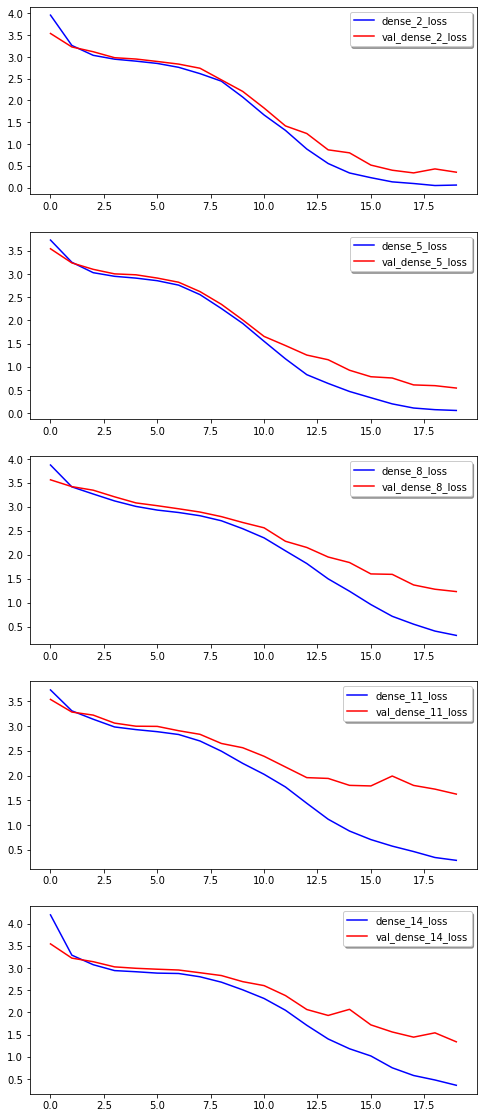

In [25]:
fig, axes = plt.subplots(5,1, figsize=(8,20))

for i, ax in enumerate(axes.flatten()):
    ax.plot(history.history[keys[i+1]], color='b', label=keys[i+1])
    ax.plot(history.history[keys[i+12]], color='r', label=keys[i+12])
    legend = ax.legend(loc='best', shadow=True)

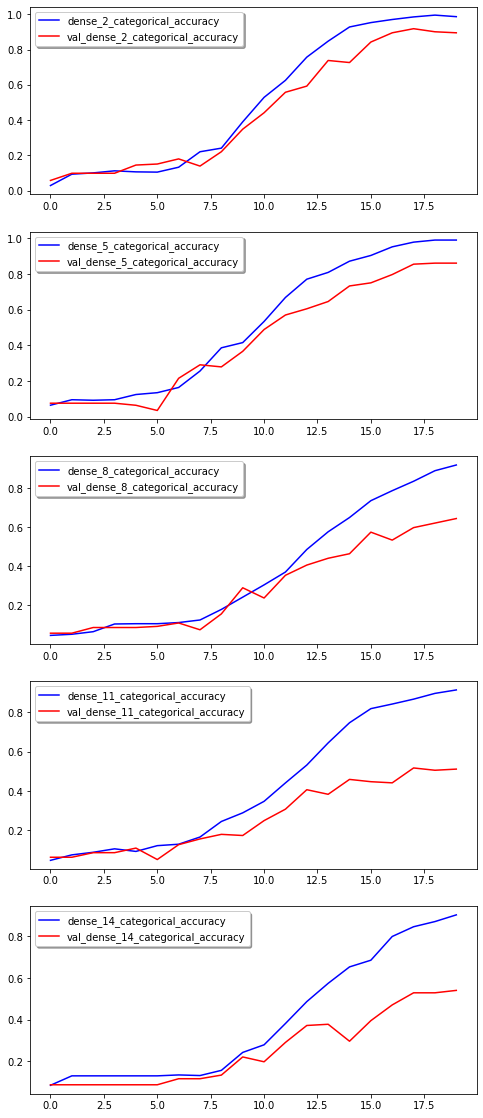

In [26]:
fig, axes = plt.subplots(5,1, figsize=(8,20))

for i, ax in enumerate(axes.flatten()):
    ax.plot(history.history[keys[i+6]], color='b', label=keys[i+6])
    ax.plot(history.history[keys[i+17]], color='r', label=keys[i+17])
    legend = ax.legend(loc='best', shadow=True)

In [27]:
gc.collect()
keras.backend.clear_session()

In [28]:
# decoded labels for Ttest
Ytrue = np.asarray(labels)[idxs[ratio:]]

In [29]:
# decode predictions for Ypred
preds = np.asarray(np.argmax(np.transpose(Ypred, (1,0,2)), axis=2), dtype=object)

for i in np.ndindex(preds.shape[:]):
    preds[i] = chars[preds[i]]
    
preds = np.asarray([''.join(i) for i in preds])

In [30]:
def plot_pred(pred, test, targets, error_only=False):
    ypred = pred # decoded predictions
    ytest = test # test set
    ytargets = targets # test classes
    
    fig, axes = plt.subplots(3,3, figsize=(16,8))
    used_idx = [] # store used images
    color = ' ' # color of title
    b = 0 # break counter
    
    for i, ax in enumerate(axes.flatten()):
        idx = np.random.randint(0, len(ytest), dtype=int)
        
        while idx in used_idx or (error_only and ypred[idx] == ytargets[idx]):
            idx = np.random.randint(0, len(ytest), dtype=int)
            b += 1
            # break condition
            if b == len(ytargets):
                b = 0
                break;
        
        used_idx.append(idx)
        
        ax.imshow(ytest[idx], cmap='gray')
        
        if ypred[idx] == ytargets[idx]:
            color = 'g'
        else:
            color = 'r'
        
        ax.set_title('Frame: ' + str(idx) + '\nPrediction: ' + str(ypred[idx]) + '\nTarget: ' + str(ytargets[idx]), color=color)
    
    fig.tight_layout()

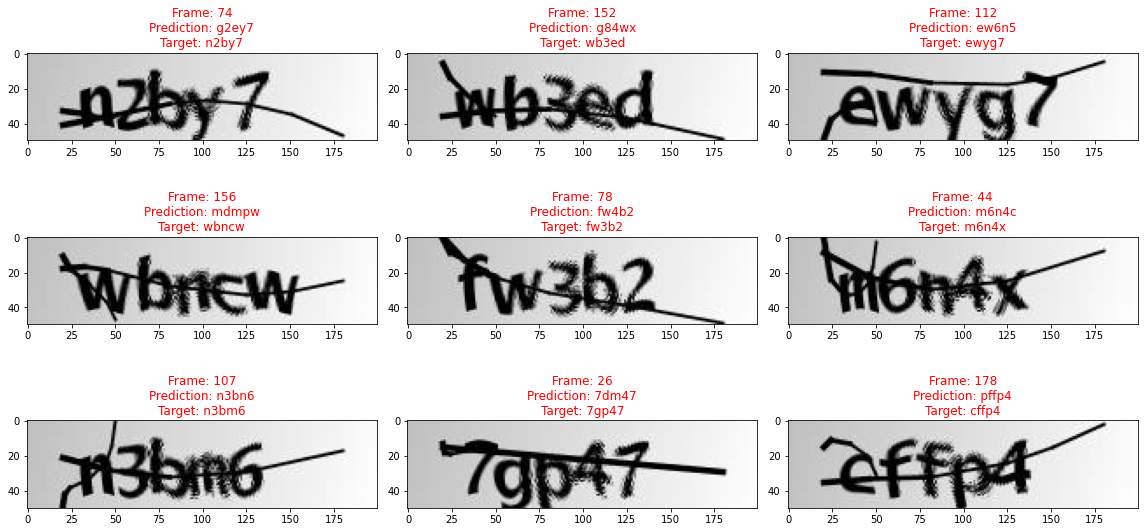

In [31]:
plot_pred(preds, Xtest, Ytrue, error_only=True)